In [297]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
from torch.optim import Adam

## circular model

In [298]:
St = [19950.]
It = [50.]
Rt = [0.]

N = 20000.

dt = 0.4
Tt = 0.
T = 4000.

beta = 1 / 60
delta = 1 / 200
xi = 1 / 1000

while Tt < T:
    Tt += dt

    dS = (xi * Rt[-1]) - (beta * St[-1] * It[-1] / N)
    dI = (beta * St[-1] * It[-1] / N) - delta * It[-1]
    dR = (delta * It[-1]) - (xi * Rt[-1])

    S = St[-1] + (dt * dS)
    I = It[-1] + (dt * dI)
    R = Rt[-1] + (dt * dR)

    St.append(S)
    It.append(I)
    Rt.append(R)


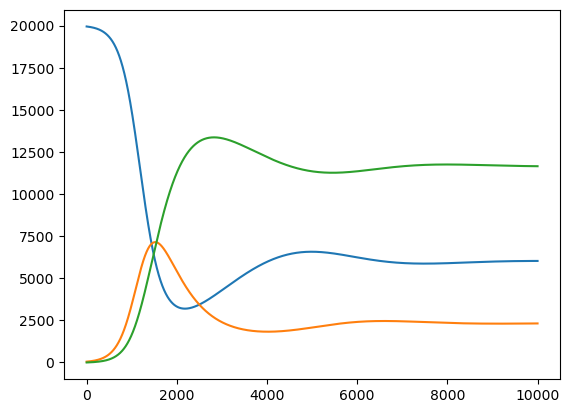

In [299]:
plt.plot(St)
plt.plot(It)
plt.plot(Rt)

## 14 day sick period

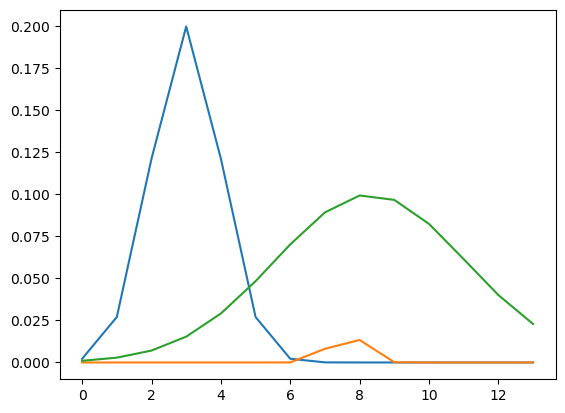

In [300]:
beta_x = 0.2 * torch.exp(-(torch.arange(14) - 3)**2 / 2)
gamma_x = 0.02 * torch.exp(-(torch.arange(14) - 7.6)**2 / 0.4)
delta_x = 0.1 * torch.exp(-(torch.arange(14) - 8.3)**2 / 15)

delta = 0.2 # recovered delta

plt.plot(beta_x) # propensity for infection
plt.plot(gamma_x) # lethality
plt.plot(delta_x) # recovery

In [301]:
N = 20_000.

Itx = [torch.zeros(14)]
Itx[0][0] = 50.
St = [N - Itx[0][0].item()]
Rt = [0]
Dt = [0]

for _ in range(40): # simulate days
    Dtx_ = Itx[-1] * gamma_x
    Rtx_ = Itx[-1] * delta_x
    
    Itx_aux = 1. * Itx[-1]
    
    Itx_ = torch.zeros(14)
    Itx_aux -= (Dtx_ + Rtx_)
    
    Itx_[0] = torch.sum(beta_x * Itx_aux) * St[-1] / N # new cases as a function of intensity
    Itx_[1:] = Itx_aux[:-1]
    
    St_ = St[-1] - (torch.sum(beta_x * Itx_aux).item() * St[-1] / N) + (delta * Rt[-1])
    Dt_ = Dt[-1] + Dtx_.sum().item()
    Rt_ = Rt[-1] + Rtx_.sum().item() + Itx_aux[-1].item() - (delta * Rt[-1])
    
    Itx.append(Itx_)
    St.append(St_)
    Rt.append(Rt_)
    Dt.append(Dt_)

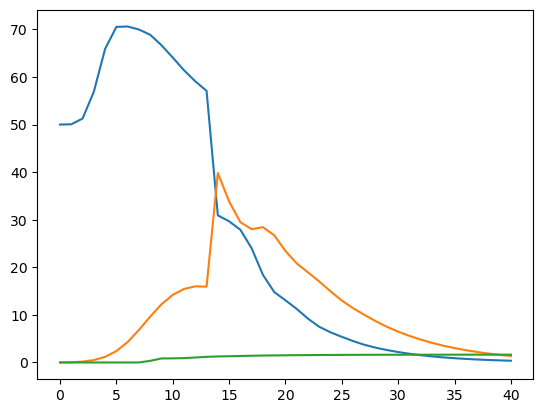

In [302]:
#plt.plot(St)
plt.plot([a.sum().item() for a in Itx])
plt.plot(Rt)
plt.plot(Dt)

## time dependent parameters -- see how well this works and then reverse engineer it using NN

In [338]:
N = 50000.

S0 = N - 100.
I0 = 100.
D0 = 0.
R0 = 0.


St = [S0]
It = [I0]
Rt = [R0]
Dt = [D0]

dt = 1

beta_time_series = 0.11 + 0.02 * np.sin(np.arange(100) / 5)
alpha = 0.01
delta = 0.01
gamma_time_series = 0.1 / (1 - np.exp(-(10 + np.arange(100)) / 50))

for i in range(100):

    beta = beta_time_series[i]
    gamma = gamma_time_series[i]

    dS = (gamma * Rt[-1]) - (beta * St[-1] * It[-1] / N)
    dI = (beta * St[-1] * It[-1] / N) - (alpha + delta) * It[-1]
    dR = (alpha * It[-1]) - (gamma * Rt[-1])
    dD = delta * It[-1]

    S = St[-1] + (dt * dS)
    I = It[-1] + (dt * dI)
    R = Rt[-1] + (dt * dR)
    D = Dt[-1] + (dt * dD)

    St.append(S)
    It.append(I)
    Rt.append(R)
    Dt.append(D)


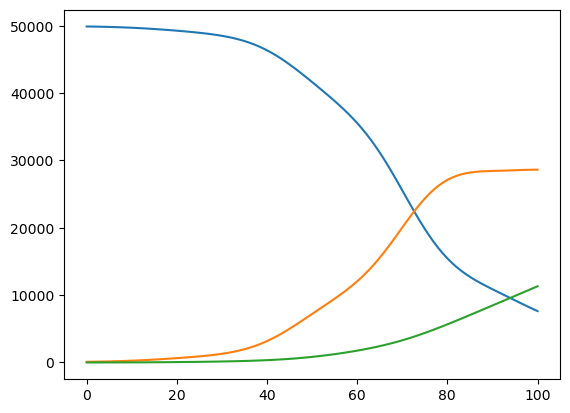

In [339]:
plt.plot(St)
plt.plot(It)
plt.plot(Dt)